<a href="https://colab.research.google.com/github/nitron-alpha-kplr/Generative-IA/blob/main/vae_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👖 Variational Autoencoders - Fashion-MNIST Dataset


> ### **!!! Attention :**

> #### **Avant de commencer le workshop, uploader les fichiers joignants au notebook dans le repository github "Generative IA"**


* L'objectif principal de cet atelier est de vous guider à travers la mise en place d'un Variational Autoencoder (VAE) en utilisant l'ensemble de données Fashion MNIST.

* Commencez par l'importation des différentes librairies que vous aurez besoin à savoir : Numpy, Matplotlib, et bien sur Tensorflow et Keras.

In [1]:
import autoreload
?autoreload
# Then you get all the above

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

from utils import display

## 0. Parameters <a name="parameters"></a>

In [3]:
# Configuration des paramètres pour l'entraînement de votre VAE.
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## 1. Prepare the data <a name="prepare"></a>

* L'ensemble de données est préinstallé avec TensorFlow, donc il peut être téléchargé comme suit :

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


* Ce sont des images en niveaux de gris de 28 × 28 pixels (valeurs de pixels entre 0 et 255) par défaut, que nous devons prétraiter pour nous assurer que les valeurs de pixels sont mises à l'échelle entre 0 et 1.

* Nous allons également ajouter un padding à chaque image pour la redimensionner en 32 × 32 pixels, ce qui facilitera la manipulation de la forme du tensor lorsqu'il traverse le réseau.

In [5]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

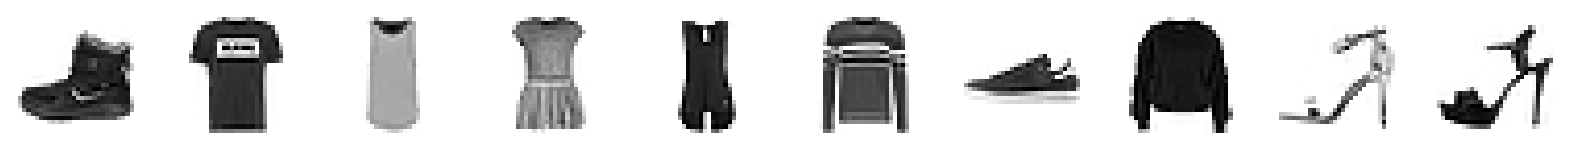

In [6]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the variational autoencoder <a name="build"></a>

## **2.1 Explications**

### **2.1.1 Subclassing de la classe Layer**

Vous pouvez créer de nouvelles couches dans Keras en sous-classant la classe Layer abstraite et en définissant la méthode call, qui décrit comment un tenseur est transformé par la couche.

Par exemple, dans l'autoencodeur variationnel, nous pouvons créer une couche d'échantillonnage (Sampling layer) qui peut gérer l'échantillonnage de z à partir d'une distribution normale avec des paramètres définis par z_mean et z_log_var.

Cela est utile lorsque vous souhaitez appliquer une transformation à un tenseur qui n'est pas déjà inclus parmi les types de couches Keras préconfigurées.

### **2.1.2 Le tour de réparamétrisation**

Au lieu d'échantillonner directement à partir d'une distribution normale avec les paramètres z_mean et z_log_var, nous pouvons échantillonner epsilon à partir d'une distribution normale standard, puis ajuster manuellement l'échantillon pour qu'il ait la moyenne et la variance correctes.

Cela est connu sous le nom de "tour de réparamétrisation" (reparameterization trick), et c'est important car cela signifie que les gradients peuvent se propager librement à travers la couche. En gardant toute la composante aléatoire de la couche contenue dans la variable epsilon, la dérivée partielle de la sortie de la couche par rapport à son entrée peut être montrée comme déterministe (c'est-à-dire indépendante de la valeur aléatoire epsilon), ce qui est essentiel pour permettre la rétropropagation à travers la couche.

## **2.2 Code**
* Tout d'abord, nous devons créer un nouveau type de couche d'échantillonnage (Sampling layer) qui nous permettra d'échantillonner à partir de la distribution définie par z_mean et z_log_var.

Pour se faire :
* Nous créons une nouvelle couche en sous-classant la classe de base Layer de Keras.
* Nous utilisons la technique de réparamétrisation pour générer un échantillon à partir de la distribution normale paramétrée par z_mean et z_log_var.

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [9]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

*  Le code suivant montre comment nous construisons le modèle VAE global en tant que sous-classe de la classe abstraite Keras Model.

* Cela nous permet d'inclure le calcul du terme de divergence KL (KL divergence) de la fonction de perte dans une méthode de train personnalisée (custom train_step).

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    # Cette fonction décrit ce que nous aimerions obtenir lorsque nous appelons le VAE sur une image d'entrée particulière.
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    # Cette fonction décrit une étape d'entraînement du VAE, y compris le calcul de la fonction de perte.

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            # La perte totale est la somme de la perte de reconstruction et de la perte de divergence KL.
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [16]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [12]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

* Nous pouvons maintenant entraîner l'autoencodeur VAE en utilisant les images d'entrée à la fois comme entrée et sortie.

In [17]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 [==============================] - ETA: 0s - total_loss: 160.2521 - reconstruction_loss: 155.8548 - kl_loss: 4.3974

600/600 [==============================] - 197s 324ms/step - total_loss: 160.2521 - reconstruction_loss: 155.8548 - kl_loss: 4.3974 - val_loss: 140.8888 - val_reconstruction_loss: 135.8002 - val_kl_loss: 5.0886
Epoch 2/5
600/600 [==============================] - ETA: 0s - total_loss: 135.2464 - reconstruction_loss: 130.2645 - kl_loss: 4.9819

600/600 [==============================] - 190s 316ms/step - total_loss: 135.2464 - reconstruction_loss: 130.2645 - kl_loss: 4.9819 - val_loss: 137.3686 - val_reconstruction_loss: 132.2598 - val_kl_loss: 5.1089
Epoch 3/5
600/600 [==============================] - ETA: 0s - total_loss: 133.7076 - reconstruction_loss: 128.6658 - kl_loss: 5.0419

600/600 [==============================] - 191s 318ms/step - total_loss: 133.7076 - reconstruction_loss: 128.6658 - kl_loss: 5.0419 - val_loss: 136.9722 - val_reconstruction_loss: 131.7680 - val_kl_loss: 5.2042
Epoch 4/5
600/600 [==============================] - ETA: 0s - total_loss: 132.9269 - reconstruction_loss: 127.8346 - kl_loss: 5.0923

600/600 [==============================] - 190s 317ms/step - total_loss: 132.9269 - reconstruction_loss: 127.8346 - kl_loss: 5.0923 - val_loss: 136.0319 - val_reconstruction_loss: 130.7542 - val_kl_loss: 5.2776
Epoch 5/5
600/600 [==============================] - ETA: 0s - total_loss: 132.3498 - reconstruction_loss: 127.2253 - kl_loss: 5.1246

600/600 [==============================] - 189s 314ms/step - total_loss: 132.3498 - reconstruction_loss: 127.2253 - kl_loss: 5.1246 - val_loss: 135.5479 - val_reconstruction_loss: 130.2513 - val_kl_loss: 5.2966


In [18]:
# Sauvegardez les modèles
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

* Nous pouvons tester maintenant la capacité de l'autoencodeur VAE à reconstruire des images en faisant passer des images de l'ensemble de test à travers le VAE et en comparant la sortie avec les images originales.

In [19]:
# Sélectionner un sous-ensemble de l'ensemble de test.
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 6s 36ms/step
Example real clothing items


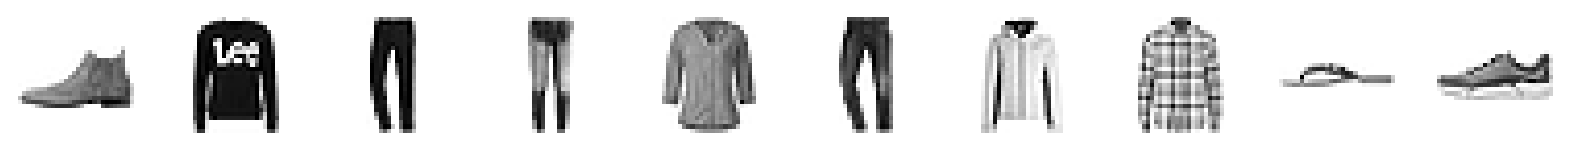

Reconstructions


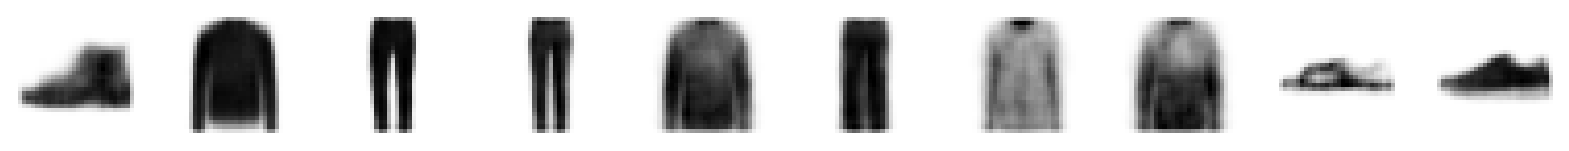

In [20]:
# Créer des prédictions de l'autoencodeur et les afficher.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Embed using the encoder <a name="encode"></a>

* Nous pouvons visualiser comment les images sont intégrées dans l'espace latent.

In [21]:
# Encoder les images d'exemple
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 1s 5ms/step


In [22]:
# Quelques exemples des intégrations (embeddings).
print(z[:10])

[[-1.2228146e+00 -1.8639733e-01]
 [ 1.3498267e+00 -1.1340423e+00]
 [ 8.6327219e-01  2.4780395e+00]
 [ 2.1168441e-03  2.0846152e+00]
 [ 3.7773672e-01 -5.3403682e-01]
 [ 6.8884909e-01  1.6340013e+00]
 [ 1.9989833e-01  9.6649729e-02]
 [ 3.7904412e-01 -3.9955738e-01]
 [-2.6102543e+00  6.2303072e-01]
 [-2.1930003e+00 -3.1572542e-01]]


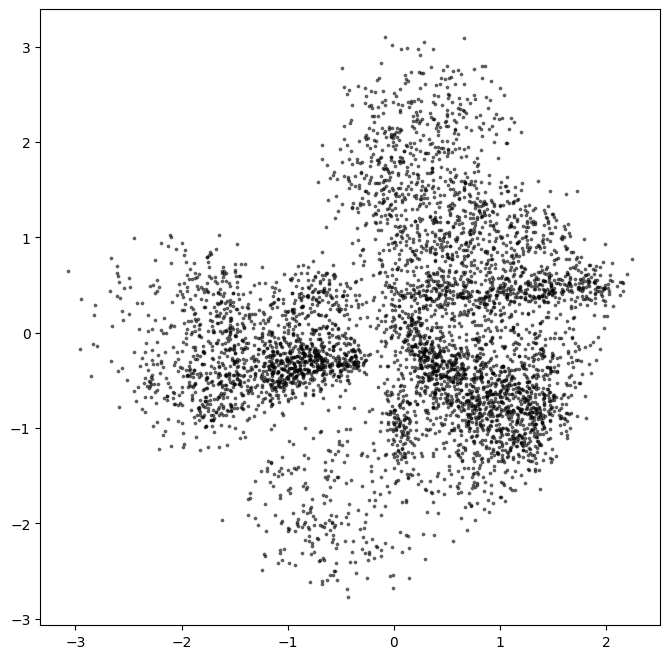

In [23]:
# Afficher les points encodés dans un espace en 2D.
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [24]:
# Échantillonner quelques points dans l'espace latent à partir de la distribution normale standard.
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [25]:
# Décoder les points échantillonnés.
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 119ms/step


In [26]:
# Convertir les intégrations d'origine et les intégrations échantillonnées en valeurs p.
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

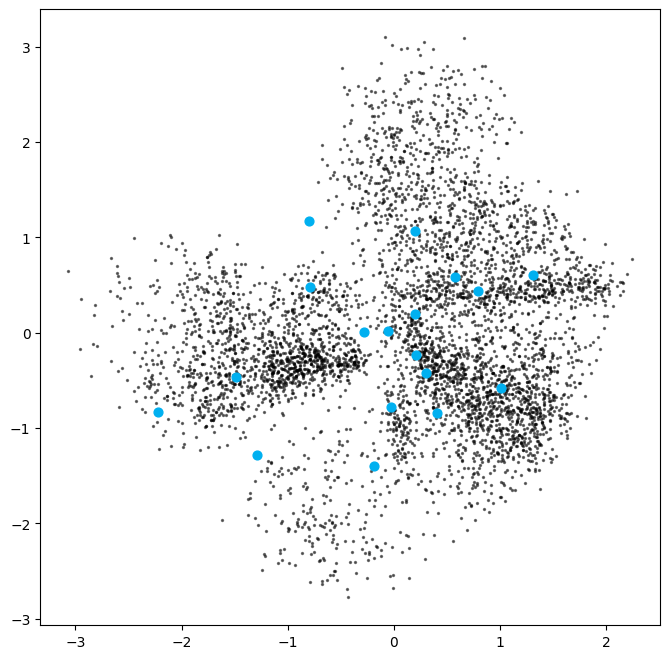

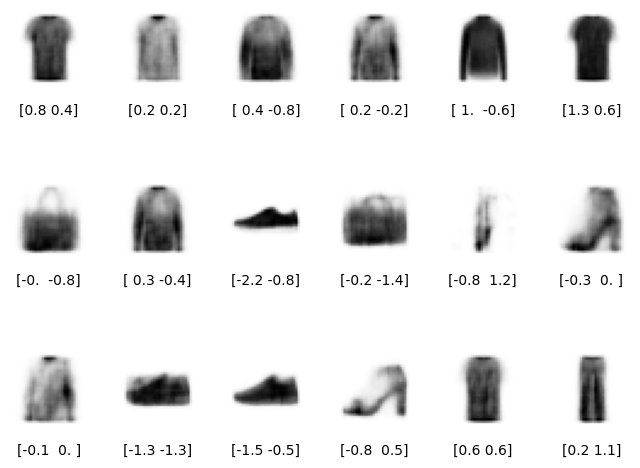

In [27]:
# Tracez un graphique de...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... les intégrations d'origine ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... et les points nouvellement générés dans l'espace latent.
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Ajoutez en dessous une grille des images décodées.
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

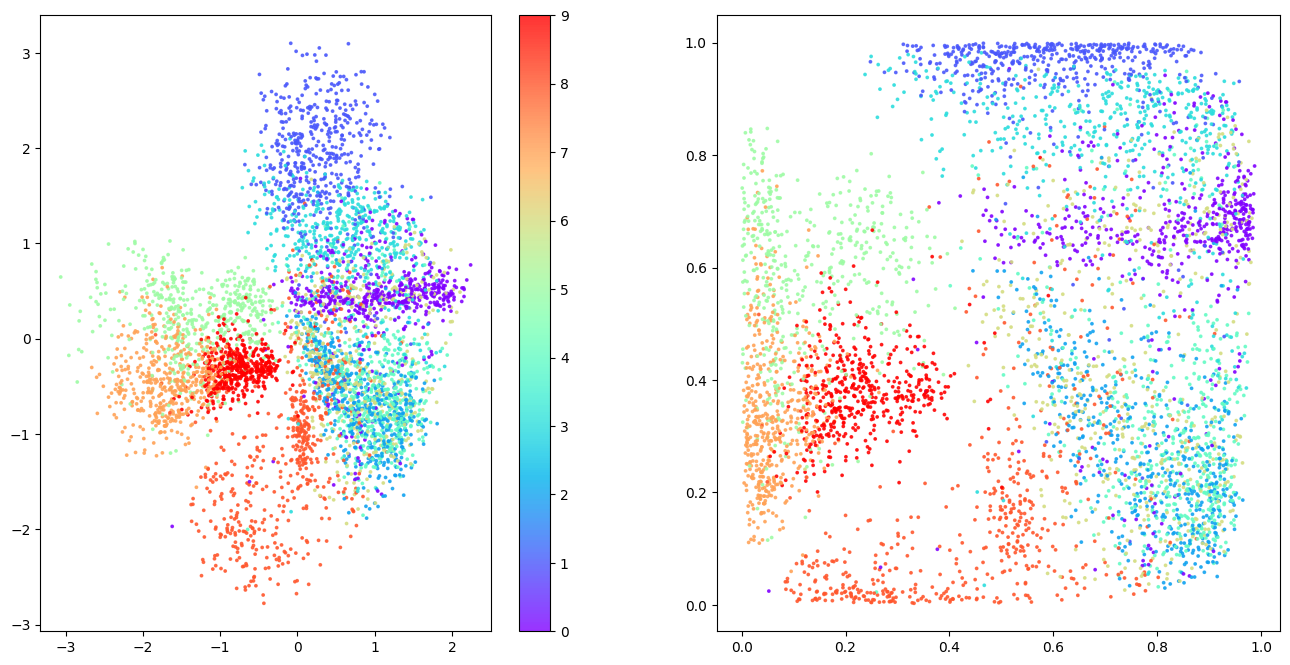

In [28]:
# Coloriez les intégrations en fonction de leur étiquette (type de vêtement - voir tableau).
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 [==============================] - 0s 25ms/step


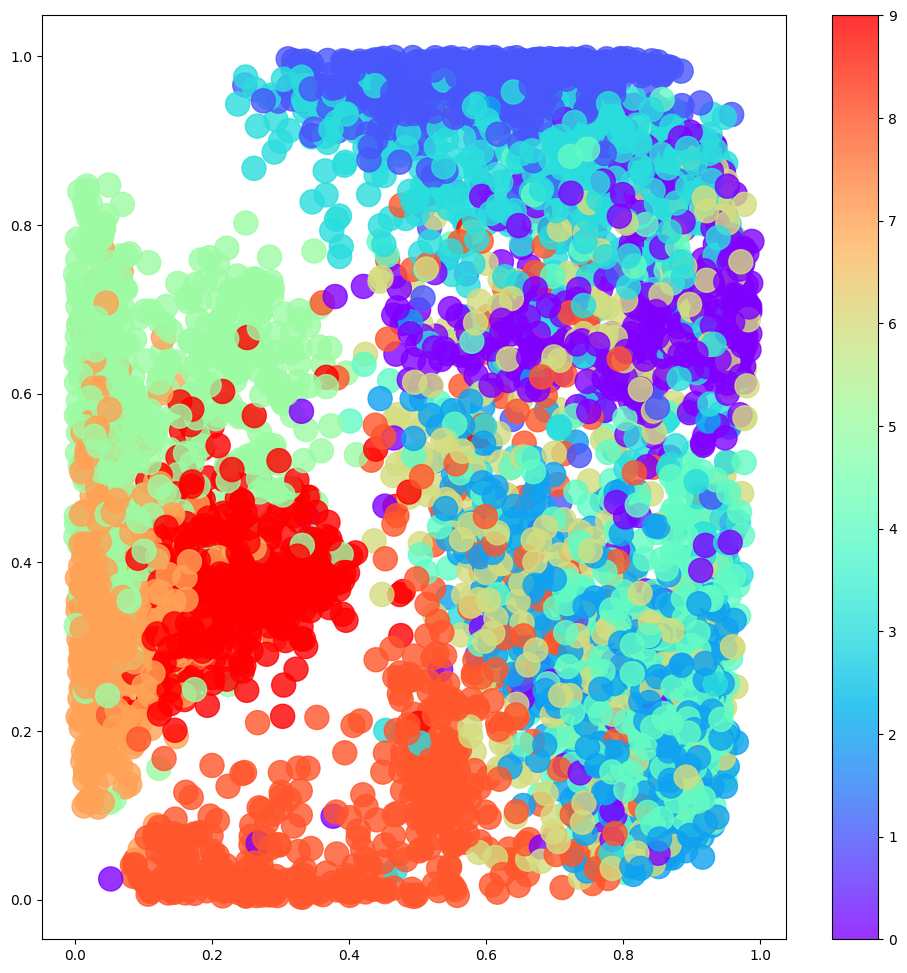

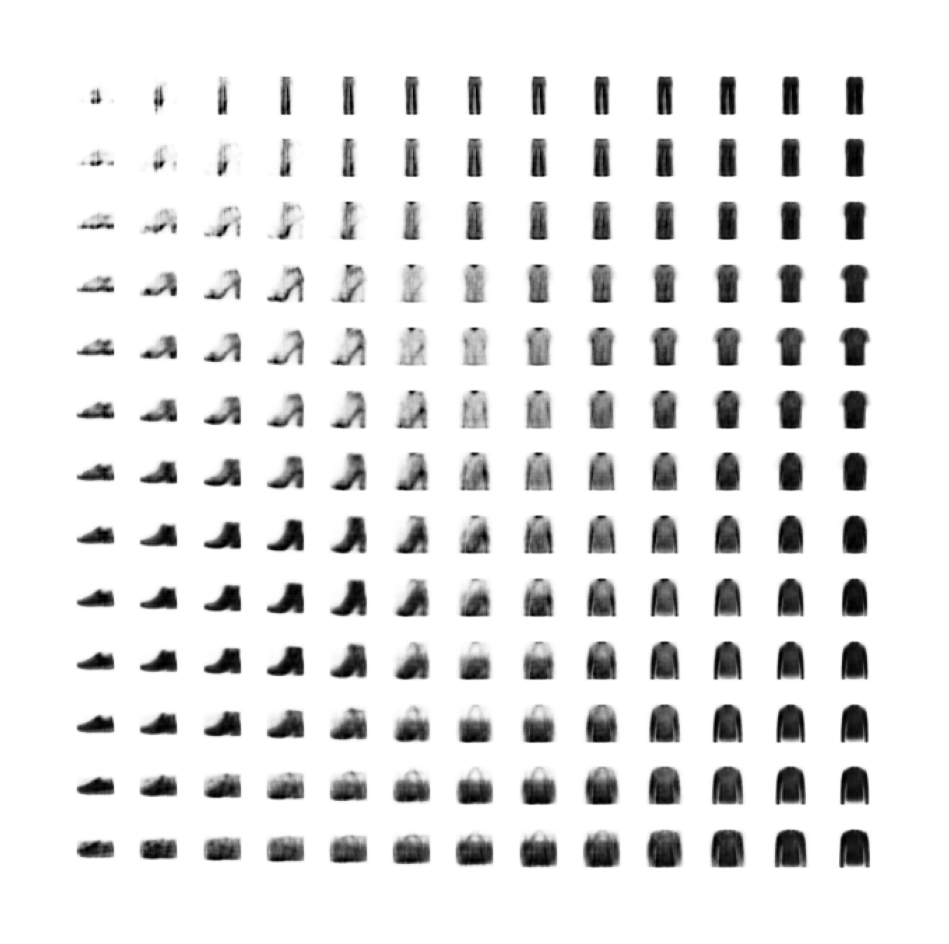

In [29]:
# Coloriez les intégrations en fonction de leur étiquette (type de vêtement - voir tableau).
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")